# Using Q-learning to solve CartPole problem

### Import the necessary libraries
- gym contains the environment
- math is for some math functions
- numpy is for managing data
- pyplot and seaborn are for data visualization

In [1]:
import gym
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Create agent
Most of this code was originally implemented by Isaac Patole. His work can be accessed [here](https://github.com/IsaacPatole/CartPole-v0-using-Q-learning-SARSA-and-DNN/blob/master/Qlearning_for_cartpole.py). However, some comments were added to the code and additional functions were implemented so that the ensemble model could access a probability vector for decision making.

In [2]:
"""
Base code taken from: 
https://github.com/IsaacPatole/CartPole-v0-using-Q-learning-SARSA-and-DNN/blob/master/Qlearning_for_cartpole.py
"""

class CartPoleQAgent():
    def __init__(self, buckets=(3, 3, 6, 6), 
                 num_episodes=500, min_lr=0.1, 
                 min_epsilon=0.1, discount=1.0, decay=25):
        self.buckets = buckets
        self.num_episodes = num_episodes
        self.min_lr = min_lr
        self.min_epsilon = min_epsilon
        self.discount = discount
        self.decay = decay

        self.env = gym.make('CartPole-v0')
        
        # This is the action-value function being initialized to 0's
        self.Q_table = np.zeros(self.buckets + (self.env.action_space.n,))

        # [position, velocity, angle, angular velocity]
        self.upper_bounds = [self.env.observation_space.high[0], 0.5, self.env.observation_space.high[2], math.radians(50) / 1.]
        self.lower_bounds = [self.env.observation_space.low[0], -0.5, self.env.observation_space.low[2], -math.radians(50) / 1.]
        
        #
        self.steps = np.zeros(self.num_episodes)
        
        

    def discretize_state(self, obs):
        """
        Takes an observation of the environment and aliases it.
        By doing this, very similar observations can be treated
        as the same and it reduces the state space so that the 
        Q-table can be smaller and more easily filled.
        
        Input:
        obs (tuple): Tuple containing 4 floats describing the current
                     state of the environment.
        
        Output:
        discretized (tuple): Tuple containing 4 non-negative integers smaller 
                             than n where n is the number in the same position
                             in the buckets list.
        """
        discretized = list()
        for i in range(len(obs)):
            scaling = ((obs[i] + abs(self.lower_bounds[i])) 
                       / (self.upper_bounds[i] - self.lower_bounds[i]))
            new_obs = int(round((self.buckets[i] - 1) * scaling))
            new_obs = min(self.buckets[i] - 1, max(0, new_obs))
            discretized.append(new_obs)
        return tuple(discretized)

    def choose_action(self, state):
        """
        Implementation of e-greedy algorithm. Returns an action (0 or 1).
        
        Input:
        state (tuple): Tuple containing 4 non-negative integers within
                       the range of the buckets.
        
        Output:
        (int) Returns either 0 or 1
        """
        if (np.random.random() < self.epsilon):
            return self.env.action_space.sample() 
        else:
            return np.argmax(self.Q_table[state])
        
    def get_action(self, state, e):
        """
        Another policy based on the Q-table. Slight variation from 
        e-greedy. It assumes the state fed hasn't been discretized and 
        returns a vector with probabilities for each action.
        
        Input: 
        state (tuple): Contains the 4 floats used to describe
                       the current state of the environment.
        e (int): Denotes the episode at which the agent is supposed
                 to be, helping balance exploration and exploitation.
                 
        Output:
        action_vector (numpy array): Vector containing the probability
                                     of each action being chosen at the
                                     current state.
        """
        obs = self.discretize_state(state)
        action_vector = self.Q_table[obs]
        epsilon = self.get_epsilon(e)
        action_vector = self.normalize(action_vector, epsilon)
        return action_vector

    def normalize(self, action_vector, epsilon):
        """
        Returns a vector with components adding to 1. Ensures 
        
        Input:
        action_vector (numpy array): Contains expected values for each
                                     action at current state from Q-table.
        epsilon (float): Chances that the e-greedy algorithm would 
                         choose an action at random. With this pol
        
        Output:
        new_vector (numpy array): Vector containing the probability
                                  of each action being chosen at the
                                  current state.
        """
        
        total = sum(action_vector)
        new_vector = (1-epsilon)*action_vector/(total)
        new_vector += epsilon/2.0
        return new_vector

    def update_q(self, state, action, reward, new_state):
        """
        Updates Q-table using the rule as described by Sutton and Barto in
        Reinforcement Learning.
        """
        self.Q_table[state][action] += (self.learning_rate * 
                                        (reward 
                                         + self.discount * np.max(self.Q_table[new_state]) 
                                         - self.Q_table[state][action]))

    def get_epsilon(self, t):
        """Gets value for epsilon. It declines as we advance in episodes."""
        # Ensures that there's almost at least a min_epsilon chance of randomly exploring
        return max(self.min_epsilon, min(1., 1. - math.log10((t + 1) / self.decay)))

    def get_learning_rate(self, t):
        """Gets value for learning rate. It declines as we advance in episodes."""
        # Learning rate also declines as we add more episodes
        return max(self.min_lr, min(1., 1. - math.log10((t + 1) / self.decay)))

    def train(self):
        """
        Trains agent making it go through the environment and choose actions
        through an e-greedy policy and updating values for its Q-table. The 
        agent is trained by default for 500 episodes with a declining 
        learning rate and epsilon values that with the default values,
        reach the minimum after 198 episodes.
        """
        # Looping for each episode
        for e in range(self.num_episodes):
            # Initializes the state
            current_state = self.discretize_state(self.env.reset())

            self.learning_rate = self.get_learning_rate(e)
            self.epsilon = self.get_epsilon(e)
            done = False
            
            # Looping for each step
            while not done:
                self.steps[e] += 1
                # Choose A from S
                action = self.choose_action(current_state)
                # Take action
                obs, reward, done, _ = self.env.step(action)
                new_state = self.discretize_state(obs)
                # Update Q(S,A)
                self.update_q(current_state, action, reward, new_state)
                current_state = new_state
                
                # We break out of the loop when done is False which is
                # a terminal state.
        print('Finished training!')
    
    def plot_learning(self):
        """
        Plots the number of steps at each episode and prints the
        amount of times that an episode was successfully completed.
        """
        sns.lineplot(range(len(self.steps)),self.steps)
        plt.xlabel("Episode")
        plt.ylabel("Steps")
        plt.show()
        t = 0
        for i in range(self.num_episodes):
            if self.steps[i] == 200:
                t+=1
        print(t, "episodes were successfully completed.")
        

    def run(self):
        """Runs an episode while displaying the cartpole environment."""
        self.env = gym.wrappers.Monitor(self.env,'cartpole')
        t = 0
        done = False
        current_state = self.discretize_state(self.env.reset())
        while not done:
                self.env.render()
                t = t+1
                action = self.choose_action(current_state)
                obs, reward, done, _ = self.env.step(action)
                new_state = self.discretize_state(obs)
                current_state = new_state
            
        return t   

### Train agent and plot results
The following function returns an agent trained with the default values. In its process, it also displays its progress during the training session.

In [3]:
def load_q_learning():
    agent = CartPoleQAgent()
    agent.train()
    agent.plot_learning()

    return agent

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Finished training!


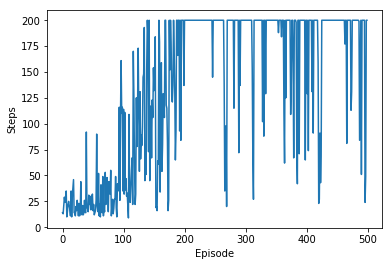

268 episodes were successfully completed.


In [4]:
agent = load_q_learning()